In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import pickle

# For reproducibility
np.random.seed(42)


In [17]:
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

#### 1. DATA LOADING

In [8]:

#############################################################
# 1. DATA LOADING
#############################################################
# Load the data (adjust paths as needed)
train_path = '../data/train_updated.csv'
test_path = '../data/test_updated.csv'
dt = pd.read_csv(train_path, low_memory=False)
dt_test = pd.read_csv(test_path, low_memory=False)
print('Train data shape:', dt.shape, 'Test data shape:', dt_test.shape)



Train data shape: (1118822, 52) Test data shape: (9272, 51)


#### 2. FEATURE PREPARATION

In [9]:
# Mark train and test data
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])

# Rename columns for easier handling
concat = concat.rename(columns={'전용면적(㎡)': '전용면적'})

# Handle missing values - replace placeholders with np.nan
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

# Filter high-missing columns (>90% missing)
missing_rates = concat.isnull().sum() / concat.shape[0]
selected_columns = [col for col in concat.columns if missing_rates[col] <= 0.9]
concat_select = concat[selected_columns]

# Ensure 거래유형 is included
if '거래유형' not in concat_select.columns:
    concat_select.loc[:, '거래유형'] = concat['거래유형']

# Convert numeric columns that are actually categorical
concat_select.loc[:, '본번'] = concat_select['본번'].astype('str')
concat_select.loc[:, '부번'] = concat_select['부번'].astype('str')

# Identify continuous and categorical columns
continuous_columns = []
categorical_columns = []
for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

# Remove target, is_test from continuous_columns if they exist
if 'target' in continuous_columns:
    continuous_columns.remove('target')
if 'is_test' in continuous_columns:
    continuous_columns.remove('is_test')

print(f"Continuous columns: {len(continuous_columns)}")
print(f"Categorical columns: {len(categorical_columns)}")

# Fill missing values
for col in categorical_columns:
    concat_select.loc[:, col] = concat_select[col].fillna('NULL')
    
for col in continuous_columns:
    concat_select.loc[:, col] = concat_select[col].interpolate(method='linear', axis=0)

/tmp/ipykernel_2335405/3687121859.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select.loc[:, '거래유형'] = concat['거래유형']
/tmp/ipykernel_2335405/3687121859.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select.loc[:, '본번'] = concat_select['본번'].astype('str')
/tmp/ipykernel_2335405/3687121859.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Continuous columns: 17
Categorical columns: 28


/tmp/ipykernel_2335405/3687121859.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select.loc[:, col] = concat_select[col].interpolate(method='linear', axis=0)


#### 3. FEATURE ENGINEERING

In [10]:
#############################################################
# 3. FEATURE ENGINEERING
#############################################################
# Split geographic and time information
concat_select['구'] = concat_select['시군구'].str.split().str[1]
concat_select['동'] = concat_select['시군구'].str.split().str[2]
concat_select.drop(['시군구'], axis=1, inplace=True)

concat_select['계약년'] = concat_select['계약년월'].astype('str').str[:4]
concat_select['계약월'] = concat_select['계약년월'].astype('str').str[4:]
concat_select.drop(['계약년월'], axis=1, inplace=True)

# Create Gangnam indicator
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
concat_select['강남여부'] = concat_select['구'].apply(lambda x: 1 if x in gangnam else 0)

# Create new building indicator
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)



/tmp/ipykernel_2335405/1188936476.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select['구'] = concat_select['시군구'].str.split().str[1]
/tmp/ipykernel_2335405/1188936476.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_select['동'] = concat_select['시군구'].str.split().str[2]
/tmp/ipykernel_2335405/1188936476.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

#### 4. DATA SPLITTING

In [11]:
#############################################################
# 4. DATA SPLITTING
#############################################################
# Split back into train and test
train_data = concat_select[concat_select['is_test'] == 0]
test_data = concat_select[concat_select['is_test'] == 1]

# Create feature and target variables
X_train = train_data.drop(['target', 'is_test'], axis=1)
y_train = train_data['target']
X_test = test_data.drop(['target', 'is_test'], axis=1, errors='ignore')

# Split training data into train and validation sets
X_train_dev, X_val, y_train_dev, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)




#### 5. PREPROCESSING PIPELINE

/tmp/ipykernel_2335405/630516340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_dev.loc[:, col] = lbl.transform(X_train_dev[col].astype(str))
/tmp/ipykernel_2335405/630516340.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train_dev.loc[:, col] = lbl.transform(X_train_dev[col].astype(str))
/tmp/ipykernel_2335405/630516340.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

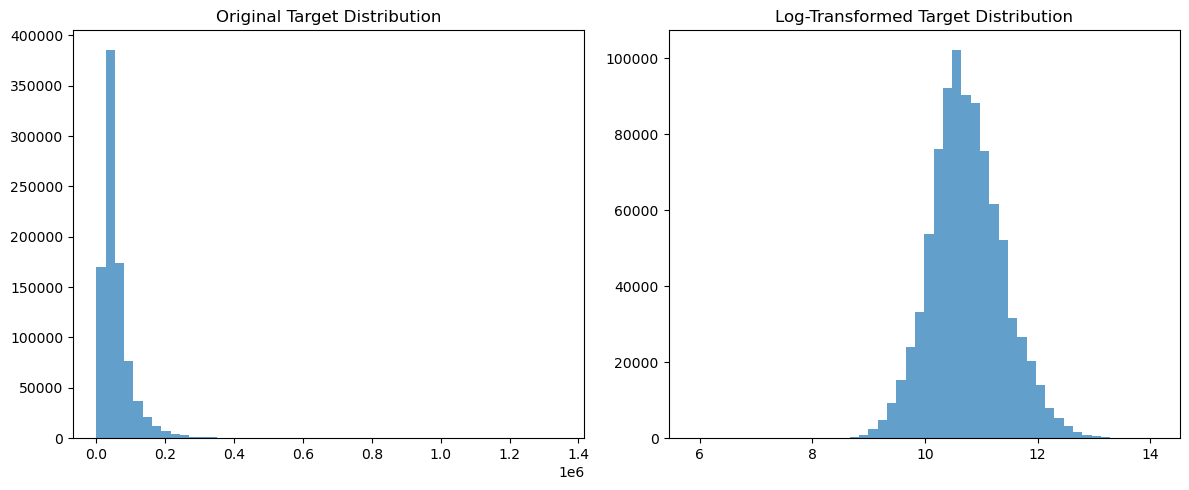

In [12]:
#############################################################
# 5. PREPROCESSING PIPELINE
#############################################################
# Update categorical columns list after feature engineering
categorical_columns = [col for col in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[col])]
continuous_columns = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]

# Label encode categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

for col in categorical_columns:
    lbl = LabelEncoder()
    # Fit on all data to handle all possible categories
    all_values = pd.concat([X_train_dev[col], X_val[col], X_test[col]]).astype(str).unique()
    lbl.fit(all_values)
    
    # Transform each dataset
    X_train_dev.loc[:, col] = lbl.transform(X_train_dev[col].astype(str))
    X_val.loc[:, col] = lbl.transform(X_val[col].astype(str))
    X_test.loc[:, col] = lbl.transform(X_test[col].astype(str))
    
    # Save encoder for later use
    label_encoders[col] = lbl

# Robust scale continuous features
feature_scaler = RobustScaler()
X_train_dev_cont = X_train_dev[continuous_columns].copy()
X_train_dev.loc[:, continuous_columns] = feature_scaler.fit_transform(X_train_dev_cont)

X_val_cont = X_val[continuous_columns].copy()
X_val.loc[:, continuous_columns] = feature_scaler.transform(X_val_cont)

X_test_cont = X_test[continuous_columns].copy()
X_test.loc[:, continuous_columns] = feature_scaler.transform(X_test_cont)

# Log transform the target (better for price data)
# First, check if we need an offset for negative values
min_val = min(y_train_dev.min(), y_val.min())
offset = abs(min_val) + 1 if min_val <= 0 else 0

# Apply log transformation
y_train_dev_log = np.log1p(y_train_dev + offset)
y_val_log = np.log1p(y_val + offset)

# Save original targets for evaluation
y_train_dev_original = y_train_dev.copy()
y_val_original = y_val.copy()

# Visualization of target before and after transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train_dev, bins=50, alpha=0.7)
plt.title('Original Target Distribution')

plt.subplot(1, 2, 2)
plt.hist(y_train_dev_log, bins=50, alpha=0.7)
plt.title('Log-Transformed Target Distribution')
plt.tight_layout()
plt.savefig('target_distribution.png')


#### 6. MODEL TRAINING

Starting model training...
[0]	validation_0-rmse:9.75833	validation_1-rmse:9.75638
[100]	validation_0-rmse:0.18715	validation_1-rmse:0.18762
[200]	validation_0-rmse:0.15301	validation_1-rmse:0.15392
[300]	validation_0-rmse:0.13913	validation_1-rmse:0.14034
[400]	validation_0-rmse:0.13016	validation_1-rmse:0.13153
[500]	validation_0-rmse:0.12357	validation_1-rmse:0.12492
[600]	validation_0-rmse:0.11830	validation_1-rmse:0.11987
[700]	validation_0-rmse:0.11406	validation_1-rmse:0.11581
[800]	validation_0-rmse:0.11062	validation_1-rmse:0.11254
[900]	validation_0-rmse:0.10770	validation_1-rmse:0.10976
[1000]	validation_0-rmse:0.10482	validation_1-rmse:0.10707
[1100]	validation_0-rmse:0.10241	validation_1-rmse:0.10492
[1200]	validation_0-rmse:0.10009	validation_1-rmse:0.10281
[1300]	validation_0-rmse:0.09810	validation_1-rmse:0.10103
[1400]	validation_0-rmse:0.09625	validation_1-rmse:0.09938
[1500]	validation_0-rmse:0.09474	validation_1-rmse:0.09811
[1600]	validation_0-rmse:0.09333	validati

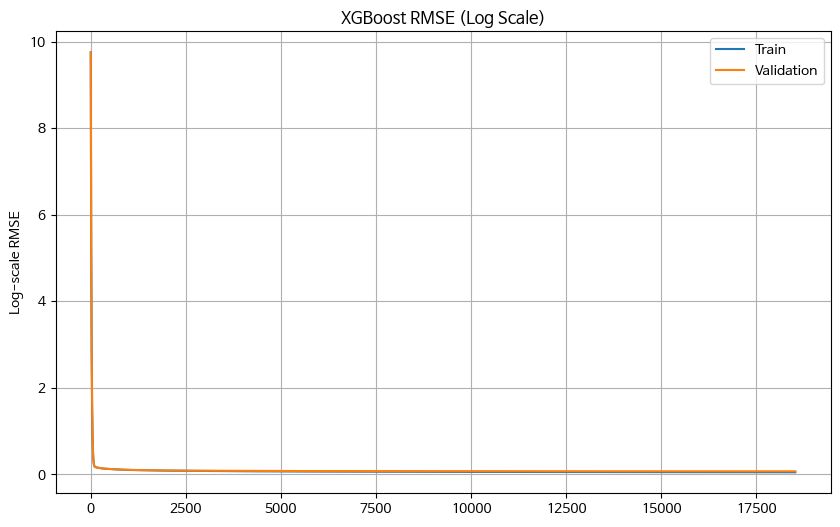

In [20]:
#############################################################
# 6. MODEL TRAINING
#############################################################


# Define XGBoost model
model_xgb = XGBRegressor(
    n_estimators=100000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=100,
    reg_alpha=0.001,
    reg_lambda=0,
    random_state=42,
    tree_method='gpu_hist' if xgb.config.get_config().get('use_gpu', False) else 'hist',
    predictor='gpu_predictor',  
)



# Train the model - simplify to avoid the custom metric error
print("Starting model training...")
model_xgb.fit(
    X_train_dev, y_train_dev_log,
    eval_set=[(X_train_dev, y_train_dev_log), (X_val, y_val_log)],
    verbose=100
)

print(f"Best iteration: {model_xgb.best_iteration}")

# Calculate and print RMSE in original scale after training
y_train_pred_log = model_xgb.predict(X_train_dev)
y_val_pred_log = model_xgb.predict(X_val)

# Convert predictions back to original scale
y_train_pred_orig = np.expm1(y_train_pred_log) - offset
y_val_pred_orig = np.expm1(y_val_pred_log) - offset

# Calculate RMSE on both sets
train_rmse_orig = np.sqrt(mean_squared_error(y_train_dev_original, y_train_pred_orig))
val_rmse_orig = np.sqrt(mean_squared_error(y_val_original, y_val_pred_orig))

print(f"Training RMSE (original scale): {train_rmse_orig:,.2f}")
print(f"Validation RMSE (original scale): {val_rmse_orig:,.2f}")

# Plot learning curves for log-scale RMSE
epochs = len(model_xgb.evals_result()['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, model_xgb.evals_result()['validation_0']['rmse'], label='Train')
plt.plot(x_axis, model_xgb.evals_result()['validation_1']['rmse'], label='Validation')
plt.legend()
plt.ylabel('Log-scale RMSE')
plt.title('XGBoost RMSE (Log Scale)')
plt.grid(True)
plt.savefig('learning_curves.png')


#### Plot learning curves

#### 7. MODEL EVALUATION

Validation RMSE: 5859.33


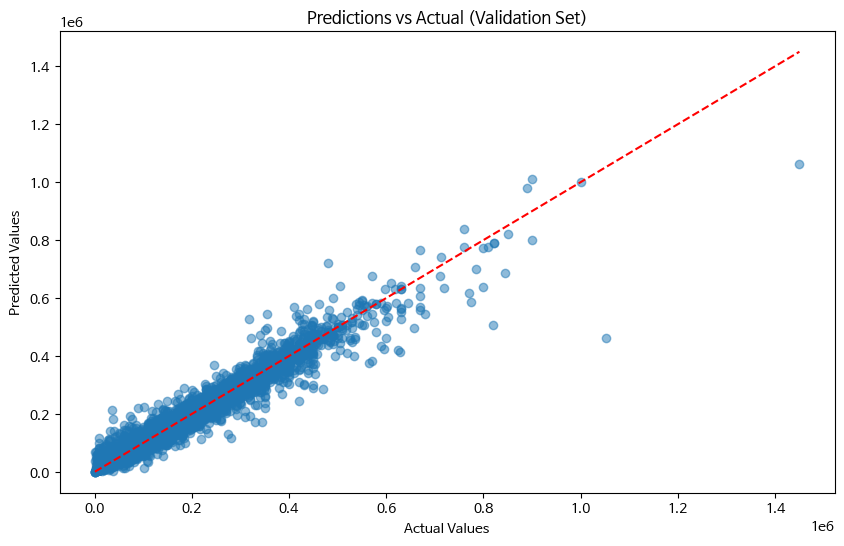

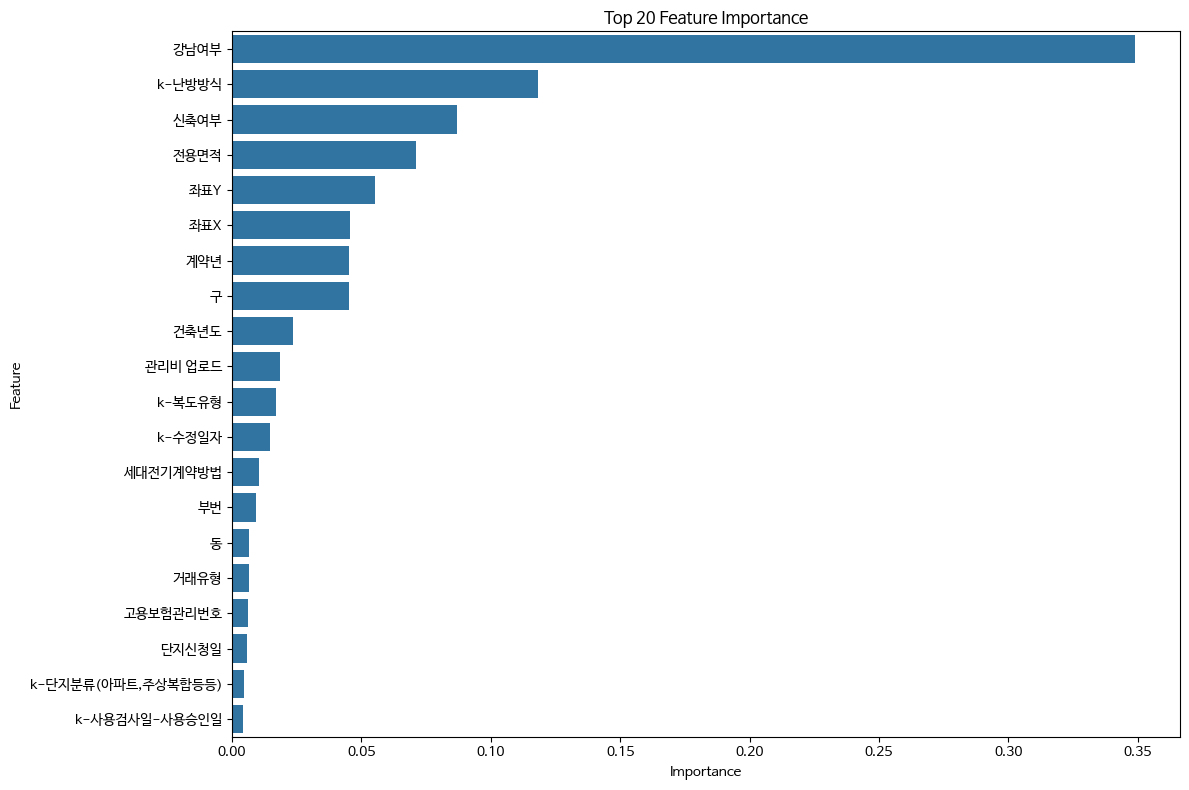

In [21]:
# Make predictions on validation set (in log space)
val_pred_log = model_xgb.predict(X_val)

# Transform back to original scale
val_pred_original = np.expm1(val_pred_log) - offset

# Calculate RMSE
val_rmse = np.sqrt(mean_squared_error(y_val_original, val_pred_original))
print(f'Validation RMSE: {val_rmse:.2f}')

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_val_original, val_pred_original, alpha=0.5)
plt.plot([y_val_original.min(), y_val_original.max()], 
         [y_val_original.min(), y_val_original.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual (Validation Set)')
plt.savefig('validation_predictions.png')

# Feature importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_xgb.feature_importances_
})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')

#### 7.1 ERROR ANALYSIS VISUALIZATION

Overpredictions (predicted > actual): 42
Underpredictions (predicted < actual): 58


/tmp/ipykernel_2335405/1630308739.py:64: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/tmp/ipykernel_2335405/1630308739.py:65: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig('error_analysis.png')
/data/ephemeral/home/miniconda3/envs/py39-rapids-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


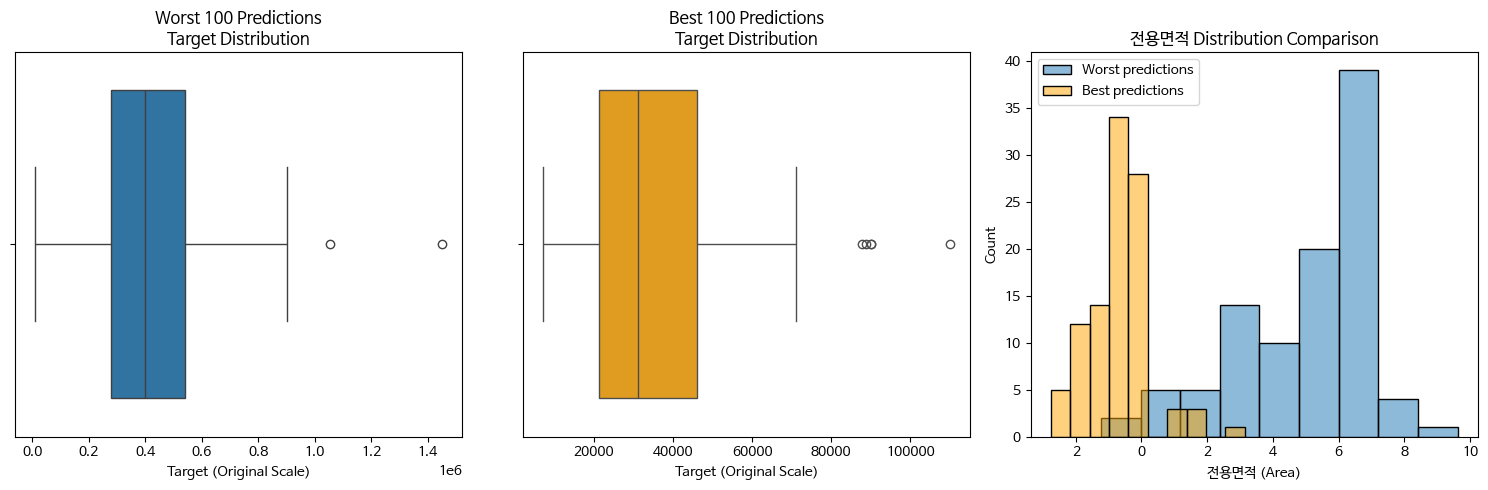

In [23]:
#############################################################
# 7.1 ERROR ANALYSIS VISUALIZATION
#############################################################
# Create a copy of validation data with predictions for analysis
X_val_analysis = X_val.copy()
X_val_analysis['target'] = y_val_original  # Use the original scale target
X_val_analysis['pred_xgb'] = val_pred_original  # Use the original scale predictions

# Calculate squared errors
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# Add error column to the dataframe
X_val_analysis['error'] = calculate_se(X_val_analysis['target'], X_val_analysis['pred_xgb'])

# Sort by error (descending)
X_val_sort = X_val_analysis.sort_values(by='error', ascending=False)

# Get worst and best 100 predictions
X_val_sort_top100 = X_val_sort.head(100)        # Worst 100 predictions
X_val_sort_tail100 = X_val_sort.tail(100)       # Best 100 predictions

# Create copies for label inverse transform
error_top100 = X_val_sort_top100.copy()
best_top100 = X_val_sort_tail100.copy()

# Inverse transform categorical columns
for column in categorical_columns:  # Use the categorical_columns list we defined earlier
    if column in error_top100.columns and column in label_encoders:
        error_top100[column] = label_encoders[column].inverse_transform(error_top100[column].astype(int))
    
    if column in best_top100.columns and column in label_encoders:
        best_top100[column] = label_encoders[column].inverse_transform(best_top100[column].astype(int))

# Calculate prediction errors (predicted - actual)
pred_minus_target = error_top100['pred_xgb'] - error_top100['target']
print(f"Overpredictions (predicted > actual): {pred_minus_target[pred_minus_target >= 0].shape[0]}")
print(f"Underpredictions (predicted < actual): {pred_minus_target[pred_minus_target < 0].shape[0]}")

# Create visualizations
plt.figure(figsize=(15, 5))

# 1. Box plot of target distribution for worst predictions
plt.subplot(1, 3, 1)
sns.boxplot(data=error_top100, x='target')
plt.title('Worst 100 Predictions\nTarget Distribution')
plt.xlabel('Target (Original Scale)')

# 2. Box plot of target distribution for best predictions
plt.subplot(1, 3, 2)
sns.boxplot(data=best_top100, x='target', color='orange')
plt.title('Best 100 Predictions\nTarget Distribution')
plt.xlabel('Target (Original Scale)')

# 3. Histogram comparing 전용면적 distribution
plt.subplot(1, 3, 3)
sns.histplot(data=error_top100, x='전용면적', alpha=0.5, label='Worst predictions')
sns.histplot(data=best_top100, x='전용면적', color='orange', alpha=0.5, label='Best predictions')
plt.title('전용면적 Distribution Comparison')
plt.xlabel('전용면적 (Area)')
plt.legend()

plt.tight_layout()
plt.savefig('error_analysis.png')
plt.show()

#### 8. INFERENCE ON TEST DATA

In [24]:
#############################################################
# 8. INFERENCE ON TEST DATA
#############################################################
# Make predictions on test data (in log space)
test_pred_log = model_xgb.predict(X_test)

# Transform back to original scale
test_pred_original = np.expm1(test_pred_log) - offset

# Convert to integers (if appropriate)
test_pred_final = np.round(test_pred_original).astype(int)

# Create submission file
submission = pd.DataFrame({'target': test_pred_final})
submission.to_csv('xgb_prediction_submission_revised.csv', index=False)

# Save the model
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump({
        'model': model_xgb,
        'feature_scaler': feature_scaler,
        'label_encoders': label_encoders,
        'offset': offset,
        'feature_names': X_train.columns.tolist(),
        'categorical_columns': categorical_columns,
        'continuous_columns': continuous_columns
    }, f)

print("Model training and prediction completed successfully!")

Model training and prediction completed successfully!
